In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split

## Set device to GPU if available

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 1. Load the Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

## Load Fashion-MNIST

In [5]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

## 2. Data Preprocessing: Split into train/val/test

In [6]:
train_indices, val_indices = train_test_split(range(len(train_dataset)), test_size=0.2, stratify=train_dataset.targets, random_state=42)

train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=64, shuffle=True)
val_loader = DataLoader(Subset(train_dataset, val_indices), batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 3. Model Design

In [7]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Instantiate models

In [8]:
ann_model = ANN().to(device)
cnn_model = CNN().to(device)

## 4. Training and Testing Function

In [9]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=classes)

    return accuracy, cm, report

## Train ANN

In [10]:
print("Training ANN...")
ann_train_losses, ann_val_losses, ann_train_accs, ann_val_accs = train_model(ann_model, train_loader, val_loader, epochs=10, lr=0.001)

Training ANN...
Epoch 1/10: Train Loss: 0.5475, Train Acc: 80.37%, Val Loss: 0.4178, Val Acc: 85.21%
Epoch 2/10: Train Loss: 0.3961, Train Acc: 85.44%, Val Loss: 0.3603, Val Acc: 86.96%
Epoch 3/10: Train Loss: 0.3555, Train Acc: 86.79%, Val Loss: 0.3534, Val Acc: 87.17%
Epoch 4/10: Train Loss: 0.3308, Train Acc: 87.78%, Val Loss: 0.3374, Val Acc: 87.82%
Epoch 5/10: Train Loss: 0.3128, Train Acc: 88.40%, Val Loss: 0.3258, Val Acc: 88.50%
Epoch 6/10: Train Loss: 0.2946, Train Acc: 89.03%, Val Loss: 0.3235, Val Acc: 88.22%
Epoch 7/10: Train Loss: 0.2814, Train Acc: 89.56%, Val Loss: 0.3140, Val Acc: 88.92%
Epoch 8/10: Train Loss: 0.2662, Train Acc: 90.10%, Val Loss: 0.3186, Val Acc: 88.58%
Epoch 9/10: Train Loss: 0.2556, Train Acc: 90.45%, Val Loss: 0.3077, Val Acc: 89.05%
Epoch 10/10: Train Loss: 0.2439, Train Acc: 90.79%, Val Loss: 0.3271, Val Acc: 88.62%


## Evaluate ANN

In [11]:
ann_acc, ann_cm, ann_report = evaluate_model(ann_model, test_loader)
print(f"ANN Test Accuracy: {ann_acc:.2f}%")
print(ann_report)

ANN Test Accuracy: 87.61%
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.82      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.75      0.86      0.80      1000
       Dress       0.88      0.89      0.88      1000
        Coat       0.78      0.82      0.80      1000
      Sandal       0.91      0.97      0.94      1000
       Shirt       0.76      0.60      0.67      1000
     Sneaker       0.91      0.95      0.93      1000
         Bag       0.96      0.97      0.96      1000
  Ankle boot       0.98      0.90      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000



## Train CNN

In [12]:
print("\nTraining CNN...")
cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs = train_model(cnn_model, train_loader, val_loader, epochs=10, lr=0.001)


Training CNN...
Epoch 1/10: Train Loss: 0.5034, Train Acc: 81.81%, Val Loss: 0.3216, Val Acc: 88.16%
Epoch 2/10: Train Loss: 0.3229, Train Acc: 88.24%, Val Loss: 0.2658, Val Acc: 90.45%
Epoch 3/10: Train Loss: 0.2740, Train Acc: 90.00%, Val Loss: 0.2647, Val Acc: 90.06%
Epoch 4/10: Train Loss: 0.2403, Train Acc: 91.15%, Val Loss: 0.2356, Val Acc: 91.30%
Epoch 5/10: Train Loss: 0.2115, Train Acc: 92.20%, Val Loss: 0.2438, Val Acc: 91.03%
Epoch 6/10: Train Loss: 0.1925, Train Acc: 92.81%, Val Loss: 0.2261, Val Acc: 92.13%
Epoch 7/10: Train Loss: 0.1734, Train Acc: 93.45%, Val Loss: 0.2213, Val Acc: 92.43%
Epoch 8/10: Train Loss: 0.1575, Train Acc: 94.11%, Val Loss: 0.2236, Val Acc: 92.45%
Epoch 9/10: Train Loss: 0.1418, Train Acc: 94.63%, Val Loss: 0.2169, Val Acc: 92.62%
Epoch 10/10: Train Loss: 0.1241, Train Acc: 95.32%, Val Loss: 0.2256, Val Acc: 92.72%


## Evaluate CNN

In [13]:
cnn_acc, cnn_cm, cnn_report = evaluate_model(cnn_model, test_loader)
print(f"CNN Test Accuracy: {cnn_acc:.2f}%")
print(cnn_report)

CNN Test Accuracy: 91.99%
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.90      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.88      0.87      1000
       Dress       0.94      0.90      0.92      1000
        Coat       0.86      0.88      0.87      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.78      0.74      0.76      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.97      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## 5. Analysis: Plot loss/acc curves and confusion matrices

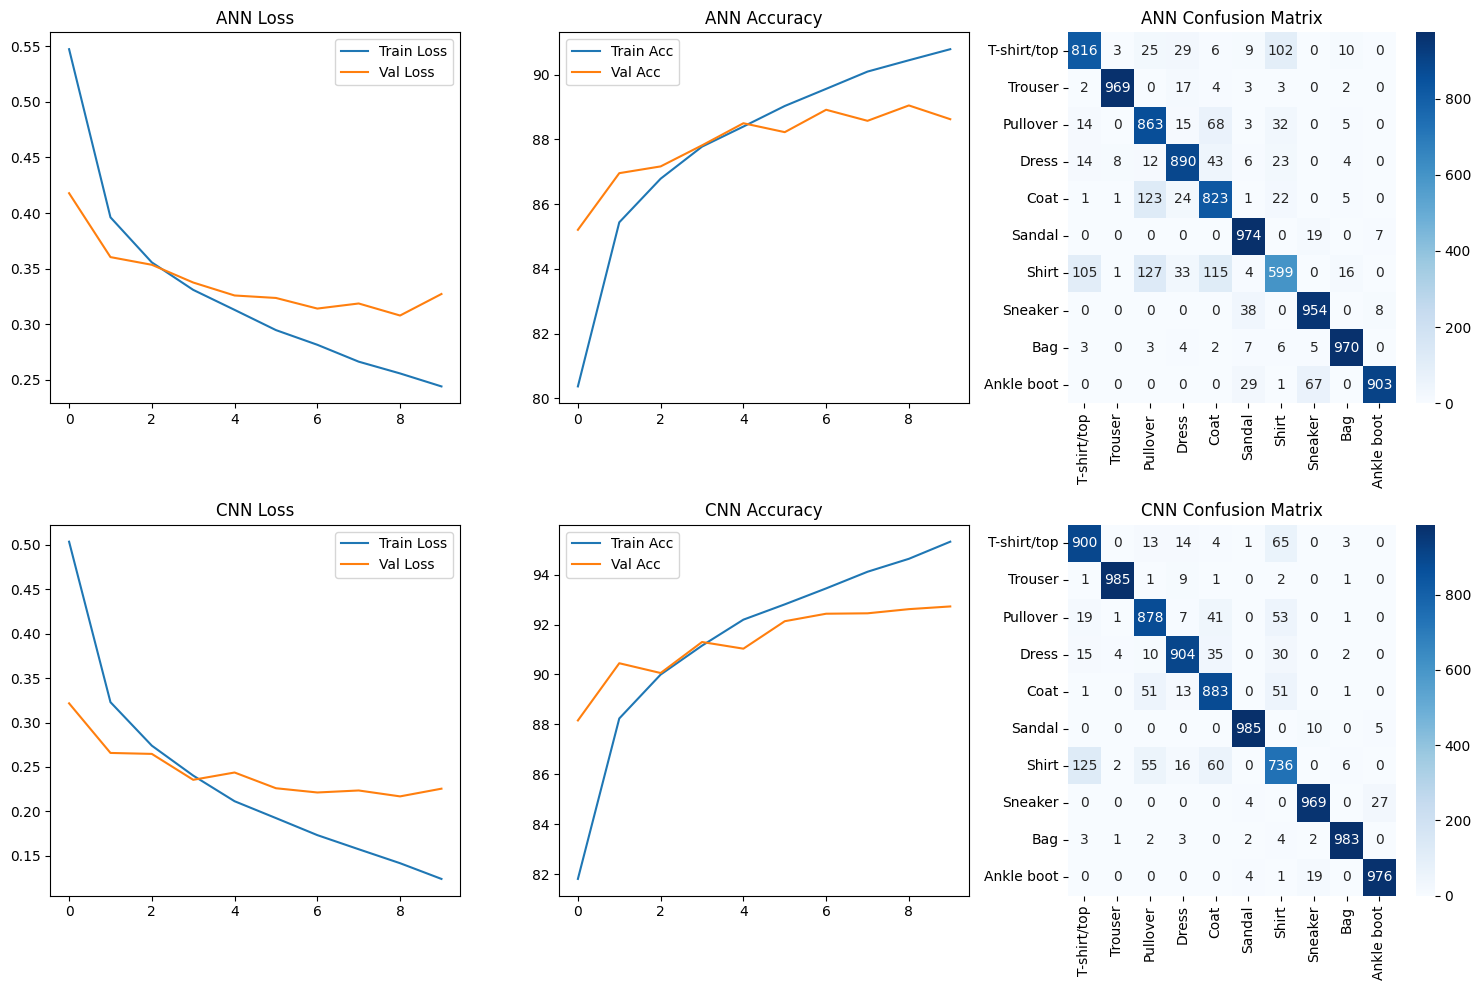


ANN Confusion (Shirt vs Coat): 115 22
CNN Confusion (Shirt vs Coat): 60 51


In [18]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# ANN Loss and Acc
axs[0, 0].plot(ann_train_losses, label='Train Loss')
axs[0, 0].plot(ann_val_losses, label='Val Loss')
axs[0, 0].set_title('ANN Loss')
axs[0, 0].legend()

axs[0, 1].plot(ann_train_accs, label='Train Acc')
axs[0, 1].plot(ann_val_accs, label='Val Acc')
axs[0, 1].set_title('ANN Accuracy')
axs[0, 1].legend()

# CNN Loss and Acc
axs[1, 0].plot(cnn_train_losses, label='Train Loss')
axs[1, 0].plot(cnn_val_losses, label='Val Loss')
axs[1, 0].set_title('CNN Loss')
axs[1, 0].legend()

axs[1, 1].plot(cnn_train_accs, label='Train Acc')
axs[1, 1].plot(cnn_val_accs, label='Val Acc')
axs[1, 1].set_title('CNN Accuracy')
axs[1, 1].legend()

# Confusion Matrices
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=axs[0, 2])
axs[0, 2].set_title('ANN Confusion Matrix')

sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=axs[1, 2])
axs[1, 2].set_title('CNN Confusion Matrix')

plt.tight_layout()
plt.savefig('results.png')  # Save plot for reference
plt.show()

# Print confusion highlights (e.g., shirt vs coat: indices 6 and 4)
print("\nANN Confusion (Shirt vs Coat):", ann_cm[6,4], ann_cm[4,6])
print("CNN Confusion (Shirt vs Coat):", cnn_cm[6,4], cnn_cm[4,6])